In [1]:
from IPython.display import Image

import sys
import pandas as pd #necessary to create dataframes and aggregate dimensional data
import numpy as np #foundational package that Pandas is built on top of
import matplotlib as mpl #necessary for charting and visualizations
from matplotlib import pyplot as plt #visualizations
from decimal import Decimal #number type

from scipy import stats #necessary for statistics calculations

##Data Analytics Packages
#SciPy Modules
from scipy.stats import zscore #data analytics
from scipy.optimize import curve_fit                
#Scikit-Learn Modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing

In [2]:
##Start of Necessary Common Code for Snowflake Table Connections##
import os
from datetime import date
from datetime import timedelta
import time
import importlib.machinery
from os.path import expanduser

cloader = importlib.machinery.SourceFileLoader('connections', expanduser("~")+'/repo/nmg-da-common/nmg/utils/connections.py')
conn = cloader.load_module('connections')
print (conn)
 
mloader = importlib.machinery.SourceFileLoader('migrations', expanduser("~")+'/repo/nmg-da-common/nmg/utils/migrations.py')
mig = mloader.load_module('migrations')
print (mig)
 
eloader = importlib.machinery.SourceFileLoader('send_mails', expanduser("~")+'/repo/nmg-da-common/nmg/utils/send_mails.py')
send = eloader.load_module('send_mails')
print (send)
 
sfcon = conn.get_snowflake_connection(env='prod', dbname='NMEDWPRD_DB')
 
sfcon.execute_string("""use database NMEDWPRD_DB; 
use schema DA_MKTSAND;""")
print(sys.version)

## End of Necessary Common Code for Snowflake Table Connections##

pd.options.display.float_format = '{:.2f}'.format

<module 'connections' from '/home/dausers/nmmz410/repo/nmg-da-common/nmg/utils/connections.py'>
<module 'migrations' from '/home/dausers/nmmz410/repo/nmg-da-common/nmg/utils/migrations.py'>
<module 'send_mails' from '/home/dausers/nmmz410/repo/nmg-da-common/nmg/utils/send_mails.py'>
3.7.16 (default, Aug 30 2023, 20:37:53) 
[GCC 7.3.1 20180712 (Red Hat 7.3.1-15)]


In [3]:
## Specify Snowflake SQL query here##

Query='''
select 
year_label,
DATEADD(day, -DAYOFWEEK(day_purchased), day_purchased) AS StartOfWeekDate,// weekly
day_purchased,
channel,
MTA.mkt_channel,
sum(WEIGHTED_DEMAND) as demand,
sum(orders) as orders,
sum(Spend) as spend

from NMEDWPRD_DB.DA_MKTSAND.JES_BGO_MIXED_MTA_14DDLINEAR_36M_T as MTA
LEFT JOIN NMEDWPRD_DB.DA_MKTSAND.MH_FUNNEL_CHANNEL_COMPILATION_BG_T as Spend
    ON MTA.day_purchased = Spend.Day
    AND MTA.MKT_CHANNEL = Spend.MKT_CHANNEL
WHERE MTA.mkt_channel IN('CSE','Performance Social','Paid TM','Display','Affiliate','Paid NonTM')
group by 1,2,3,4,5;

'''

BGO = pd.read_sql_query(Query, sfcon)  ##BGO MTA + BGO Funnel Spend


In [4]:
#Output Audit
print(BGO.describe())
print(BGO.info())

          DEMAND  ORDERS      SPEND
count    6555.00 6555.00    6159.00
mean   125648.35  167.25   22629.42
std    122919.45  176.41   31162.92
min         1.17    0.01 -365667.08
25%     22705.84   26.91    2048.75
50%     84523.95  100.25    8025.63
75%    206704.59  272.88   35548.03
max   1360828.67 1405.04  773656.83
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6555 entries, 0 to 6554
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YEAR_LABEL       6555 non-null   object 
 1   STARTOFWEEKDATE  6555 non-null   object 
 2   DAY_PURCHASED    6555 non-null   object 
 3   CHANNEL          6555 non-null   object 
 4   MKT_CHANNEL      6555 non-null   object 
 5   DEMAND           6555 non-null   float64
 6   ORDERS           6555 non-null   float64
 7   SPEND            6159 non-null   float64
dtypes: float64(3), object(5)
memory usage: 409.8+ KB
None


In [5]:
#Time Frame Check
MinDate = [BGO.groupby('MKT_CHANNEL')['DAY_PURCHASED'].min()]
MinDate

[MKT_CHANNEL
 Affiliate             2022-01-26
 CSE                   2022-01-26
 Display               2022-01-26
 Paid NonTM            2022-01-26
 Paid TM               2022-01-26
 Performance Social    2022-01-26
 Name: DAY_PURCHASED, dtype: object]

In [6]:
BGO_CSE = BGO[BGO['MKT_CHANNEL']=='CSE']
BGO_AFF = BGO[BGO['MKT_CHANNEL']=='Affiliate']
BGO_DIS = BGO[BGO['MKT_CHANNEL']=='Display']
BGO_PTM = BGO[BGO['MKT_CHANNEL']=='Paid TM']
BGO_PNTM = BGO[BGO['MKT_CHANNEL']=='Paid NonTM']
BGO_PS = BGO[BGO['MKT_CHANNEL']=='Performance Social']


In [7]:
print(BGO_PS.sort_values(by='DAY_PURCHASED'))


     YEAR_LABEL STARTOFWEEKDATE DAY_PURCHASED CHANNEL         MKT_CHANNEL  \
1810      F2022      2022-01-23    2022-01-26     BGO  Performance Social   
6542      F2022      2022-01-23    2022-01-27     BGO  Performance Social   
2764      F2022      2022-01-23    2022-01-28     BGO  Performance Social   
3070      F2022      2022-01-23    2022-01-29     BGO  Performance Social   
3765      F2022      2022-01-30    2022-01-30     BGO  Performance Social   
...         ...             ...           ...     ...                 ...   
4110      F2025      2025-01-19    2025-01-23     BGO  Performance Social   
2076      F2025      2025-01-19    2025-01-24     BGO  Performance Social   
1069      F2025      2025-01-19    2025-01-25     BGO  Performance Social   
4305      F2025      2025-01-26    2025-01-26     BGO  Performance Social   
4306      F2025      2025-01-26    2025-01-27     BGO  Performance Social   

       DEMAND  ORDERS   SPEND  
1810 13620.38   36.45     nan  
6542 23166.

In [8]:
##using the IQR method to remove outliers from each marketing channel dataframe for clear visualistion of the Spend/ Demand relationship
### outliers are defined as outside the bounds given by:  (mean spend - 1.5 * Quartile 1, mean spend + 1.5 * Quartile 3)

##BGO_CSE
CSE_demand_mean = BGO_CSE['DEMAND'].mean()
CSE_demand_std = BGO_CSE['DEMAND'].std()
CSE_spend_mean = BGO_CSE['SPEND'].mean()

CSE_Q3_spend= BGO_CSE['SPEND'].quantile(q=.75)
CSE_Q1_spend = BGO_CSE['SPEND'].quantile(q=.25)

CSE_IQR_TOP = CSE_spend_mean + 1.5*(CSE_Q3_spend)
CSE_IQR_BOTTOM = CSE_spend_mean - 1.5*(CSE_Q1_spend)

BGO_CSE_filt = BGO_CSE.loc[(BGO_CSE['SPEND']>=CSE_IQR_BOTTOM) & (BGO_CSE['SPEND']<=CSE_IQR_TOP)]
BGO_CSE_filt = BGO_CSE.loc[(BGO_CSE['SPEND']>=1)]

BGO_CSE_filt

,YEAR_LABEL,STARTOFWEEKDATE,DAY_PURCHASED,CHANNEL,MKT_CHANNEL,DEMAND,ORDERS,SPEND
0,F2025,2025-01-19,2025-01-19,BGO,CSE,326418.28,378.96,56452.34
24,F2023,2023-06-25,2023-06-28,BGO,CSE,346829.47,548.51,93595.62
28,F2022,2022-04-24,2022-04-25,BGO,CSE,381376.53,522.61,68669.79
55,F2025,2024-08-25,2024-08-29,BGO,CSE,191281.53,232.49,49290.46
63,F2023,2023-07-23,2023-07-27,BGO,CSE,282454.43,583.11,56669.09
...,...,...,...,...,...,...,...,...
6526,F2024,2024-04-21,2024-04-24,BGO,CSE,290895.80,394.58,76827.04
6530,F2023,2023-01-22,2023-01-27,BGO,CSE,212905.47,380.10,26698.34
6534,F2023,2023-02-05,2023-02-06,BGO,CSE,256786.70,466.69,81067.88
6543,F2023,2022-09-11,2022-09-12,BGO,CSE,343371.13,400.95,76469.02


In [9]:
##BGO_AFF

AFF_demand_std = BGO_AFF['DEMAND'].std()
AFF_spend_mean = BGO_AFF['SPEND'].mean()

AFF_Q3_spend= BGO_AFF['SPEND'].quantile(q=.75)
AFF_Q1_spend = BGO_AFF['SPEND'].quantile(q=.25)

AFF_IQR_TOP = AFF_spend_mean + 1.5*(AFF_Q3_spend)
AFF_IQR_BOTTOM = AFF_spend_mean - 1.5*(AFF_Q3_spend)

BGO_AFF_filt = BGO_AFF.loc[(BGO_AFF['SPEND']>=AFF_IQR_BOTTOM) & (BGO_AFF['SPEND']<=AFF_IQR_TOP)]
BGO_AFF_filt
BGO_AFF_filt = BGO_AFF_filt[BGO_AFF_filt['SPEND']>=0]

In [10]:
##BGO_DIS
DIS_demand_mean = BGO_DIS['DEMAND'].mean()
DIS_demand_std = BGO_DIS['DEMAND'].std()
DIS_spend_mean = BGO_DIS['SPEND'].mean()

DIS_Q3_spend= BGO_DIS['SPEND'].quantile(q=.75)
DIS_Q1_spend = BGO_DIS['SPEND'].quantile(q=.25)

DIS_IQR_TOP = DIS_spend_mean + 1.5*(DIS_Q3_spend)
DIS_IQR_BOTTOM = DIS_spend_mean - 1.5*(DIS_Q3_spend)

BGO_DIS_filt = BGO_DIS.loc[(BGO_DIS['SPEND']>=DIS_IQR_BOTTOM) & (BGO_DIS['SPEND']<=DIS_IQR_TOP)]
BGO_DIS_filt

,YEAR_LABEL,STARTOFWEEKDATE,DAY_PURCHASED,CHANNEL,MKT_CHANNEL,DEMAND,ORDERS,SPEND
1,F2025,2025-01-19,2025-01-21,BGO,Display,15269.90,22.90,2606.58
15,F2023,2023-04-02,2023-04-02,BGO,Display,13662.26,10.83,954.00
27,F2024,2023-11-05,2023-11-09,BGO,Display,13093.03,13.71,2657.81
46,F2024,2024-04-28,2024-05-04,BGO,Display,26068.96,21.25,4503.34
51,F2025,2024-12-08,2024-12-09,BGO,Display,9979.78,13.60,3450.38
...,...,...,...,...,...,...,...,...
6520,F2023,2022-12-18,2022-12-21,BGO,Display,28670.83,24.70,2575.60
6528,F2024,2024-01-21,2024-01-22,BGO,Display,13434.94,20.74,3364.23
6535,F2025,2024-12-29,2024-12-30,BGO,Display,7316.91,13.58,3258.31
6538,F2023,2022-11-20,2022-11-24,BGO,Display,35346.27,31.87,2432.00


In [11]:
##BGO_PTM
PTM_demand_mean = BGO_PTM['DEMAND'].mean()
PTM_demand_std = BGO_PTM['DEMAND'].std()
PTM_spend_mean = BGO_PTM['SPEND'].mean()

PTM_Q3_spend= BGO_PTM['SPEND'].quantile(q=.75)
PTM_Q1_spend = BGO_PTM['SPEND'].quantile(q=.25)

PTM_IQR_TOP = PTM_spend_mean + 1.5*(PTM_Q3_spend)
PTM_IQR_BOTTOM = PTM_spend_mean - 1.5*(PTM_Q3_spend)

BGO_PTM_filt = BGO_PTM.loc[(BGO_PTM['SPEND']>=PTM_IQR_BOTTOM) & (BGO_PTM['SPEND']<=PTM_IQR_TOP)]
BGO_PTM_filt

,YEAR_LABEL,STARTOFWEEKDATE,DAY_PURCHASED,CHANNEL,MKT_CHANNEL,DEMAND,ORDERS,SPEND
2,F2025,2025-01-19,2025-01-21,BGO,Paid TM,93449.95,97.99,3169.43
9,F2024,2023-10-01,2023-10-02,BGO,Paid TM,58514.73,70.02,1415.25
14,F2024,2024-07-07,2024-07-07,BGO,Paid TM,62427.29,89.84,1215.64
17,F2024,2024-04-28,2024-05-01,BGO,Paid TM,66264.19,71.84,2433.15
19,F2023,2022-09-11,2022-09-16,BGO,Paid TM,141630.05,213.31,1259.39
...,...,...,...,...,...,...,...,...
6519,F2024,2024-06-02,2024-06-02,BGO,Paid TM,134141.57,101.44,1064.38
6529,F2023,2023-04-30,2023-05-05,BGO,Paid TM,139264.62,123.87,2037.60
6531,F2022,2022-03-13,2022-03-16,BGO,Paid TM,156734.24,166.12,1761.36
6540,F2023,2023-02-12,2023-02-15,BGO,Paid TM,41201.59,50.92,933.19


In [12]:
##BGO_PNTM
PNTM_demand_mean = BGO_PNTM['DEMAND'].mean()
PNTM_demand_std = BGO_PNTM['DEMAND'].std()
PNTM_spend_mean = BGO_PNTM['SPEND'].mean()

PNTM_Q3_spend= BGO_PNTM['SPEND'].quantile(q=.75)
PNTM_Q1_spend = BGO_PNTM['SPEND'].quantile(q=.25)

PNTM_IQR_TOP = PNTM_spend_mean + 1.5*(PNTM_Q3_spend)
PNTM_IQR_BOTTOM = PNTM_spend_mean - 1.5*(PNTM_Q3_spend)

BGO_PNTM_filt = BGO_PNTM.loc[(BGO_PNTM['SPEND']>=PNTM_IQR_BOTTOM) & (BGO_PNTM['SPEND']<=PNTM_IQR_TOP)]
BGO_PNTM_filt

,YEAR_LABEL,STARTOFWEEKDATE,DAY_PURCHASED,CHANNEL,MKT_CHANNEL,DEMAND,ORDERS,SPEND
3,F2025,2024-09-22,2024-09-26,BGO,Paid NonTM,44134.44,30.76,8164.25
4,F2024,2024-07-21,2024-07-27,BGO,Paid NonTM,43908.05,42.33,14793.66
6,F2023,2023-07-16,2023-07-22,BGO,Paid NonTM,89193.64,94.91,26903.67
7,F2025,2024-08-25,2024-08-26,BGO,Paid NonTM,46732.13,43.82,8210.27
8,F2023,2022-10-02,2022-10-08,BGO,Paid NonTM,101519.58,113.01,32330.45
...,...,...,...,...,...,...,...,...
6527,F2025,2024-12-29,2025-01-03,BGO,Paid NonTM,31256.90,37.23,6542.12
6532,F2025,2024-12-22,2024-12-28,BGO,Paid NonTM,32295.71,41.13,6129.86
6533,F2024,2024-04-14,2024-04-18,BGO,Paid NonTM,45986.30,37.61,18048.52
6537,F2024,2023-09-03,2023-09-03,BGO,Paid NonTM,85757.37,94.72,29714.82


In [13]:
BGO_PS

,YEAR_LABEL,STARTOFWEEKDATE,DAY_PURCHASED,CHANNEL,MKT_CHANNEL,DEMAND,ORDERS,SPEND
5,F2023,2023-05-07,2023-05-08,BGO,Performance Social,11748.91,14.10,5146.05
10,F2022,2022-06-05,2022-06-08,BGO,Performance Social,27009.73,34.28,nan
21,F2024,2023-11-12,2023-11-18,BGO,Performance Social,15799.66,13.26,5448.09
31,F2025,2024-08-04,2024-08-09,BGO,Performance Social,9216.86,20.46,1634.04
41,F2022,2022-03-20,2022-03-20,BGO,Performance Social,61179.84,99.63,nan
...,...,...,...,...,...,...,...,...
6536,F2023,2022-09-11,2022-09-12,BGO,Performance Social,32916.93,36.81,nan
6542,F2022,2022-01-23,2022-01-27,BGO,Performance Social,23166.35,40.91,nan
6544,F2024,2023-12-03,2023-12-06,BGO,Performance Social,5948.64,3.43,2465.38
6552,F2024,2024-05-26,2024-05-28,BGO,Performance Social,15153.91,18.90,5841.65


In [14]:
BGO_PS = BGO_PS.dropna(subset=['SPEND'])

In [15]:
BGO_PS

,YEAR_LABEL,STARTOFWEEKDATE,DAY_PURCHASED,CHANNEL,MKT_CHANNEL,DEMAND,ORDERS,SPEND
5,F2023,2023-05-07,2023-05-08,BGO,Performance Social,11748.91,14.10,5146.05
21,F2024,2023-11-12,2023-11-18,BGO,Performance Social,15799.66,13.26,5448.09
31,F2025,2024-08-04,2024-08-09,BGO,Performance Social,9216.86,20.46,1634.04
42,F2024,2024-04-14,2024-04-17,BGO,Performance Social,9354.26,16.34,6542.37
50,F2024,2023-12-10,2023-12-10,BGO,Performance Social,1361.75,5.61,2632.69
...,...,...,...,...,...,...,...,...
6516,F2025,2024-10-06,2024-10-10,BGO,Performance Social,16257.43,8.76,3243.84
6524,F2025,2024-11-03,2024-11-03,BGO,Performance Social,36000.41,18.93,3857.71
6544,F2024,2023-12-03,2023-12-06,BGO,Performance Social,5948.64,3.43,2465.38
6552,F2024,2024-05-26,2024-05-28,BGO,Performance Social,15153.91,18.90,5841.65


In [16]:
#BGO_PS

# PS_demand_mean = BGO_PS['DEMAND'].mean()
# PS_demand_std = BGO_PS['DEMAND'].std()
# PS_spend_mean = BGO_PS['SPEND'].mean()

# PS_Q3_spend= BGO_PS['SPEND'].quantile(q=.75)
# PS_Q1_spend = BGO_PS['SPEND'].quantile(q=.25)

# PS_IQR_TOP = PNTM_spend_mean + 1.5*(PS_Q3_spend)
# PS_IQR_BOTTOM = PNTM_spend_mean - 1.5*(PS_Q3_spend)

# BGO_PS_filt = BGO_PS.loc[(BGO_PS['SPEND']>=PS_IQR_BOTTOM) & (BGO_PS['SPEND']<=PS_IQR_TOP)]
BGO_PS_filt = BGO_PS

In [17]:
print(BGO_PS_filt.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 5 to 6554
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YEAR_LABEL       702 non-null    object 
 1   STARTOFWEEKDATE  702 non-null    object 
 2   DAY_PURCHASED    702 non-null    object 
 3   CHANNEL          702 non-null    object 
 4   MKT_CHANNEL      702 non-null    object 
 5   DEMAND           702 non-null    float64
 6   ORDERS           702 non-null    float64
 7   SPEND            702 non-null    float64
dtypes: float64(3), object(5)
memory usage: 49.4+ KB
None


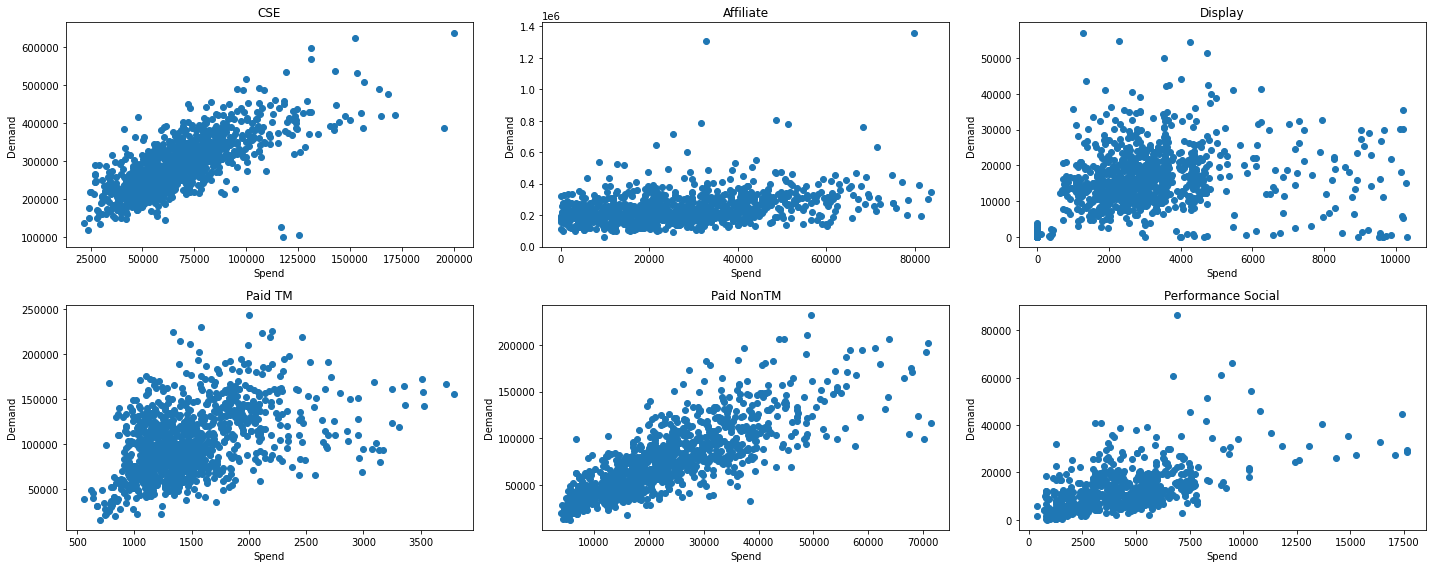

In [18]:
##creating scatter plot chart for BGO marketing channel fileterd dataframes - Daily Granularity
##scatterplot is used to visualize the trend we believe to exist between spend and demand
##we believe the trend should depict a diminishing returns relationship

fig, ax = plt.subplots(2,3,figsize=(20,8))

ax[0,0].scatter(BGO_CSE_filt[['SPEND']],BGO_CSE_filt[['DEMAND']])
ax[0,0].set_xlabel('Spend')
ax[0,0].set_ylabel('Demand')
ax[0,0].set_title('CSE')

ax[0,1].scatter(BGO_AFF_filt[['SPEND']],BGO_AFF_filt[['DEMAND']])
ax[0,1].set_xlabel('Spend')
ax[0,1].set_ylabel('Demand')
ax[0,1].set_title('Affiliate')

ax[0,2].scatter(BGO_DIS_filt[['SPEND']],BGO_DIS_filt[['DEMAND']])
ax[0,2].set_xlabel('Spend')
ax[0,2].set_ylabel('Demand')
ax[0,2].set_title('Display')

ax[1,0].scatter(BGO_PTM_filt[['SPEND']],BGO_PTM_filt[['DEMAND']])
ax[1,0].set_xlabel('Spend')
ax[1,0].set_ylabel('Demand')
ax[1,0].set_title('Paid TM')

ax[1,1].scatter(BGO_PNTM_filt[['SPEND']],BGO_PNTM_filt[['DEMAND']])
ax[1,1].set_xlabel('Spend')
ax[1,1].set_ylabel('Demand')
ax[1,1].set_title('Paid NonTM')

ax[1,2].scatter(BGO_PS_filt[['SPEND']],BGO_PS_filt[['DEMAND']])
ax[1,2].set_xlabel('Spend')
ax[1,2].set_ylabel('Demand')
ax[1,2].set_title('Performance Social')

plt.tight_layout()
plt.show()

In [19]:
##Aggregate Dataframes to weekly granularity
WK_BG_CSE  = BGO_CSE_filt.groupby('STARTOFWEEKDATE')['SPEND','DEMAND'].sum().reset_index()
WK_BG_AFF  = BGO_AFF_filt.groupby('STARTOFWEEKDATE')['SPEND','DEMAND'].sum().reset_index()
WK_BG_DIS  = BGO_DIS_filt.groupby('STARTOFWEEKDATE')['SPEND','DEMAND'].sum().reset_index()
WK_BG_PTM  = BGO_PTM_filt.groupby('STARTOFWEEKDATE')['SPEND','DEMAND'].sum().reset_index()
WK_BG_PNTM = BGO_PNTM_filt.groupby('STARTOFWEEKDATE')['SPEND','DEMAND'].sum().reset_index()
WK_BG_PS   = BGO_PS_filt.groupby('STARTOFWEEKDATE')['SPEND','DEMAND'].sum().reset_index()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (impli

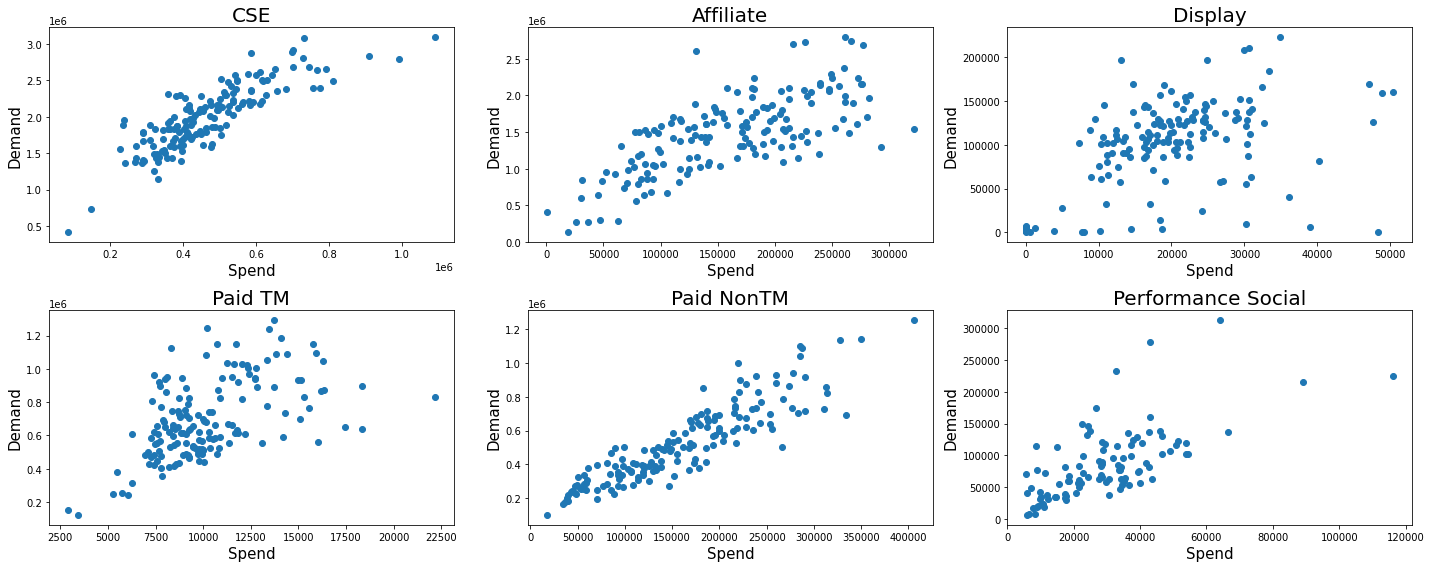

In [20]:
##Weekly Chart
##creating scatter plot chart for BGO marketing channel fileterd dataframes
##scatterplot is used to visualize the trend we believe to exist between spend and demand
##we believe the trend should depict a diminishing returns relationship

fig, ax = plt.subplots(2,3,figsize=(20,8))

ax[0,0].scatter(WK_BG_CSE['SPEND'],WK_BG_CSE['DEMAND'])
ax[0,0].set_xlabel('Spend',fontsize=15)
ax[0,0].set_ylabel('Demand',fontsize=15)
ax[0,0].set_title('CSE',fontsize=20)

ax[0,1].scatter(WK_BG_AFF['SPEND'],WK_BG_AFF['DEMAND'])
ax[0,1].set_xlabel('Spend',fontsize=15)
ax[0,1].set_ylabel('Demand',fontsize=15)
ax[0,1].set_title('Affiliate',fontsize=20)

ax[0,2].scatter(WK_BG_DIS['SPEND'],WK_BG_DIS['DEMAND'])
ax[0,2].set_xlabel('Spend',fontsize=15)
ax[0,2].set_ylabel('Demand',fontsize=15)
ax[0,2].set_title('Display',fontsize=20)

ax[1,0].scatter(WK_BG_PTM['SPEND'],WK_BG_PTM['DEMAND'])
ax[1,0].set_xlabel('Spend',fontsize=15)
ax[1,0].set_ylabel('Demand',fontsize=15)
ax[1,0].set_title('Paid TM',fontsize=20)

ax[1,1].scatter(WK_BG_PNTM['SPEND'],WK_BG_PNTM['DEMAND'])
ax[1,1].set_xlabel('Spend',fontsize=15)
ax[1,1].set_ylabel('Demand',fontsize=15)
ax[1,1].set_title('Paid NonTM',fontsize=20)

ax[1,2].scatter(WK_BG_PS['SPEND'],WK_BG_PS['DEMAND'])
ax[1,2].set_xlabel('Spend',fontsize=15)
ax[1,2].set_ylabel('Demand',fontsize=15)
ax[1,2].set_title('Performance Social',fontsize=20)

plt.tight_layout()
plt.savefig('Weekly Demand.jpg')  # Save as PDF

plt.show()


In [21]:
###ROAS calculation for all weekly aggregated marketing channel dataframes

MKT_CHNL = [WK_BG_CSE,WK_BG_AFF,WK_BG_DIS,WK_BG_PTM,WK_BG_PNTM,WK_BG_PS]

for i in MKT_CHNL:
    i['ROAS'] = i['DEMAND']/i['SPEND']

In [22]:
##Correlation analysis for each marketing channel on train spend and train demand weekly

correlations=[]

for i, df in enumerate(MKT_CHNL):
    # Calculate correlation
    correlation = df['SPEND'].corr(df['DEMAND'])
    correlations.append(correlation)

In [23]:
##Labeling correltion score values
labels = ['CSE','Affiliate','Display','Paid TM','Paid NonTM','Performance Social']
pairs = list(zip(labels,correlations))
print(pairs)

[('CSE', 0.843187847476184), ('Affiliate', 0.7161764378037538), ('Display', 0.4905842347797543), ('Paid TM', 0.5418197717962923), ('Paid NonTM', 0.8986546941055673), ('Performance Social', 0.6719196345518437)]


In [40]:
WK_BG_AFF = WK_BG_AFF[WK_BG_AFF['ROAS'] <= 500]

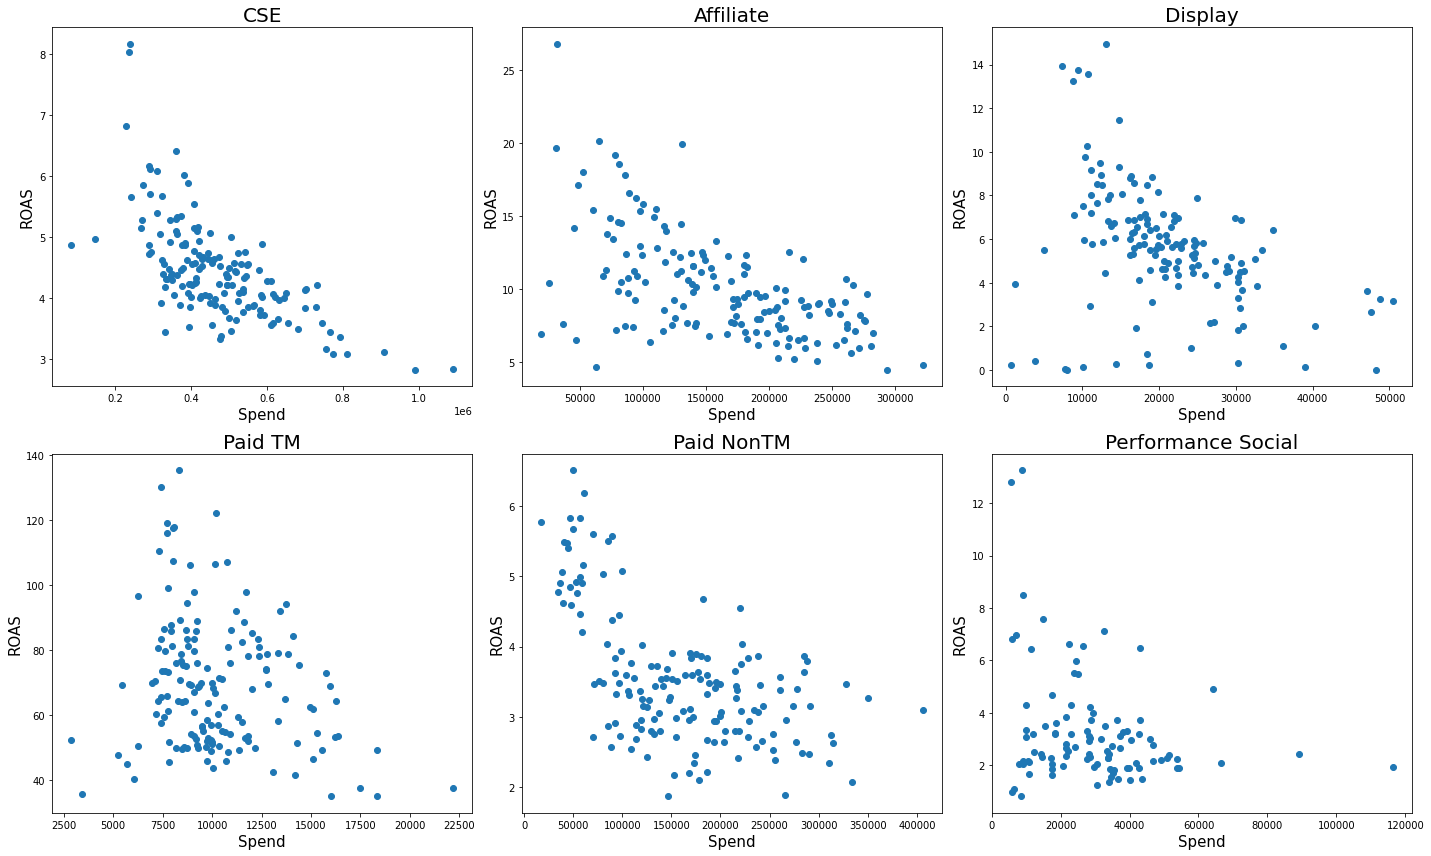

In [41]:
##Weekly Chart
##creating scatter plot chart for BGO marketing channel fileterd dataframes
##scatterplot is used to visualize the trend we believe to exist between spend and demand
##we believe the trend should depict a diminishing returns relationship

fig, ax = plt.subplots(2,3,figsize=(20,12))

ax[0,0].scatter(WK_BG_CSE['SPEND'],WK_BG_CSE['ROAS'])
ax[0,0].set_xlabel('Spend',fontsize=15)
ax[0,0].set_ylabel('ROAS',fontsize=15)
ax[0,0].set_title('CSE',fontsize=20)

ax[0,1].scatter(WK_BG_AFF['SPEND'],WK_BG_AFF['ROAS'])
ax[0,1].set_xlabel('Spend',fontsize=15)
ax[0,1].set_ylabel('ROAS',fontsize=15)
ax[0,1].set_title('Affiliate',fontsize=20)

ax[0,2].scatter(WK_BG_DIS['SPEND'],WK_BG_DIS['ROAS'])
ax[0,2].set_xlabel('Spend',fontsize=15)
ax[0,2].set_ylabel('ROAS',fontsize=15)
ax[0,2].set_title('Display',fontsize=20)

ax[1,0].scatter(WK_BG_PTM['SPEND'],WK_BG_PTM['ROAS'])
ax[1,0].set_xlabel('Spend',fontsize=15)
ax[1,0].set_ylabel('ROAS',fontsize=15)
ax[1,0].set_title('Paid TM',fontsize=20)

ax[1,1].scatter(WK_BG_PNTM['SPEND'],WK_BG_PNTM['ROAS'])
ax[1,1].set_xlabel('Spend',fontsize=15)
ax[1,1].set_ylabel('ROAS',fontsize=15)
ax[1,1].set_title('Paid NonTM',fontsize=20)

ax[1,2].scatter(WK_BG_PS['SPEND'],WK_BG_PS['ROAS'])
ax[1,2].set_xlabel('Spend',fontsize=15)
ax[1,2].set_ylabel('ROAS',fontsize=15)
ax[1,2].set_title('Performance Social',fontsize=20)
plt.savefig('Weekly ROAS.jpg')  # Save as PDF

plt.tight_layout()
plt.show()

In [42]:
###Marginal Return Function Definition
##Log Method (simplified)

def marginal_return_funct(x,a,b):
    return b*((x**a))

In [43]:
parameters = []
y_fit_mkt = []

In [44]:
##iterate through all marketing channels,
##output and append to parameter list the a and b that optimally fit spend input to actual demand

for i in MKT_CHNL:
    x_data = (i['SPEND']).values
    y_data = (i['DEMAND']).values
    x_data = x_data[~np.isnan(x_data)]
    y_data = y_data[~np.isnan(y_data)]
    
    params, covariance = curve_fit(marginal_return_funct,x_data,y_data)
    a,b = params
    parameters.append(params)
    
##using fitted parameters, calculate fitted demand using actual spend per marketing channel
    y_fit = marginal_return_funct(x_data,a,b)
    y_fit_mkt.append(y_fit)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


In [45]:
print(WK_BG_CSE)

    STARTOFWEEKDATE     SPEND     DEMAND  ROAS      Y_Fit
0        2022-01-23 147872.72  733681.48  4.96 1039630.42
1        2022-01-30 322374.14 1488647.53  4.62 1632927.10
2        2022-02-06 325327.64 1427476.29  4.39 1641577.52
3        2022-02-13 403812.83 1703406.76  4.22 1860531.51
4        2022-02-20 583054.81 2168777.00  3.72 2301746.41
..              ...       ...        ...   ...        ...
153      2024-12-29 293599.72 1398658.76  4.76 1546832.42
154      2025-01-05 271384.46 1433348.80  5.28 1477906.98
155      2025-01-12 310199.11 1674634.94  5.40 1596910.47
156      2025-01-19 345131.32 1821042.75  5.28 1698748.30
157      2025-01-26  84313.67  410755.26  4.87  750805.89

[158 rows x 5 columns]


In [46]:
WK_BG_CSE.head()

,STARTOFWEEKDATE,SPEND,DEMAND,ROAS,Y_Fit
0,2022-01-23,147872.72,733681.48,4.96,1039630.42
1,2022-01-30,322374.14,1488647.53,4.62,1632927.10
2,2022-02-06,325327.64,1427476.29,4.39,1641577.52
3,2022-02-13,403812.83,1703406.76,4.22,1860531.51
4,2022-02-20,583054.81,2168777.00,3.72,2301746.41


In [47]:
##Merge Fitted Demnand to Marketing Channel Dataframe, per channel

for df,y_fit in zip(MKT_CHNL,y_fit_mkt):
    df['Y_Fit'] = y_fit

In [48]:
WK_BG_CSE.info()
WK_BG_CSE.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STARTOFWEEKDATE  158 non-null    object 
 1   SPEND            158 non-null    float64
 2   DEMAND           158 non-null    float64
 3   ROAS             158 non-null    float64
 4   Y_Fit            158 non-null    float64
dtypes: float64(4), object(1)
memory usage: 6.3+ KB


,STARTOFWEEKDATE,SPEND,DEMAND,ROAS,Y_Fit
0,2022-01-23,147872.72,733681.48,4.96,1039630.42
1,2022-01-30,322374.14,1488647.53,4.62,1632927.10
2,2022-02-06,325327.64,1427476.29,4.39,1641577.52
3,2022-02-13,403812.83,1703406.76,4.22,1860531.51
4,2022-02-20,583054.81,2168777.00,3.72,2301746.41


In [49]:
MKT_CHNL = [WK_BG_CSE,WK_BG_AFF,WK_BG_DIS,WK_BG_PTM,WK_BG_PNTM,WK_BG_PS]
MKT_CHNL_Labels = ["CSE","Affiliate","Display","Paid TM","Paid NonTM", "Performance Social"]

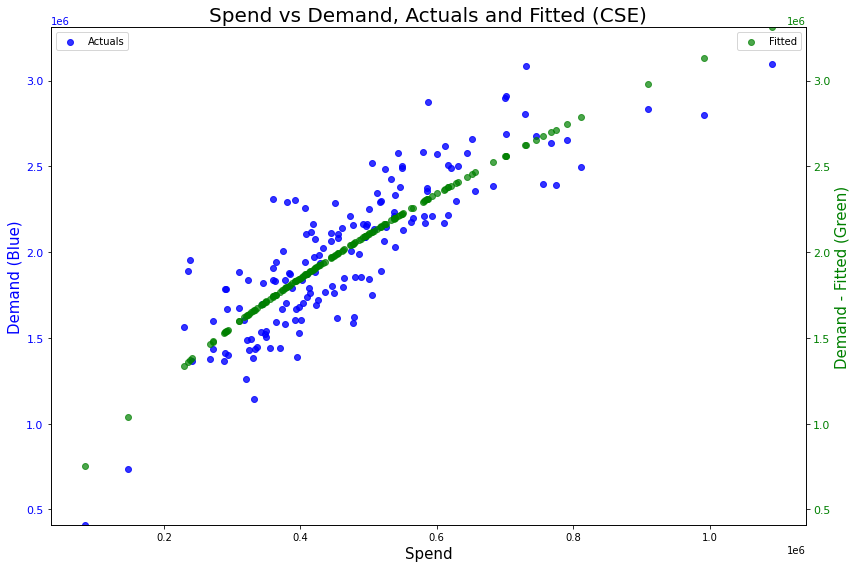

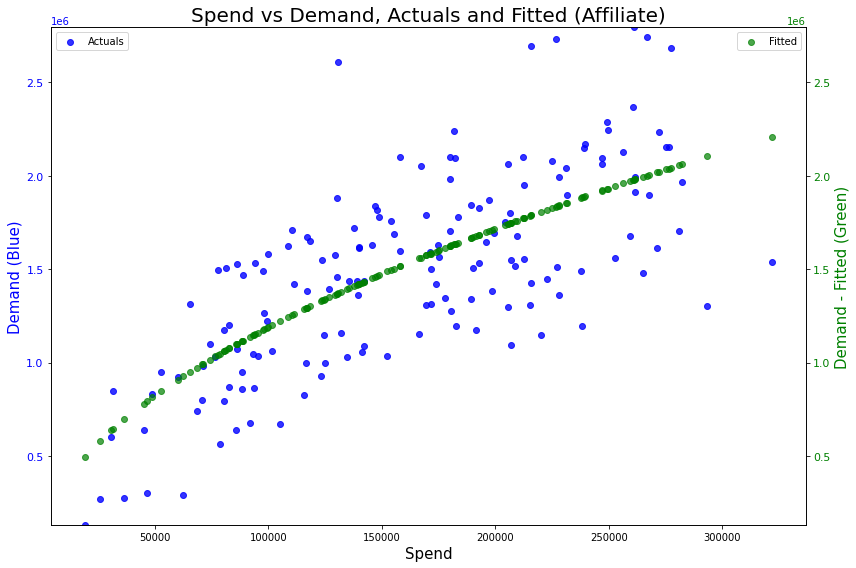

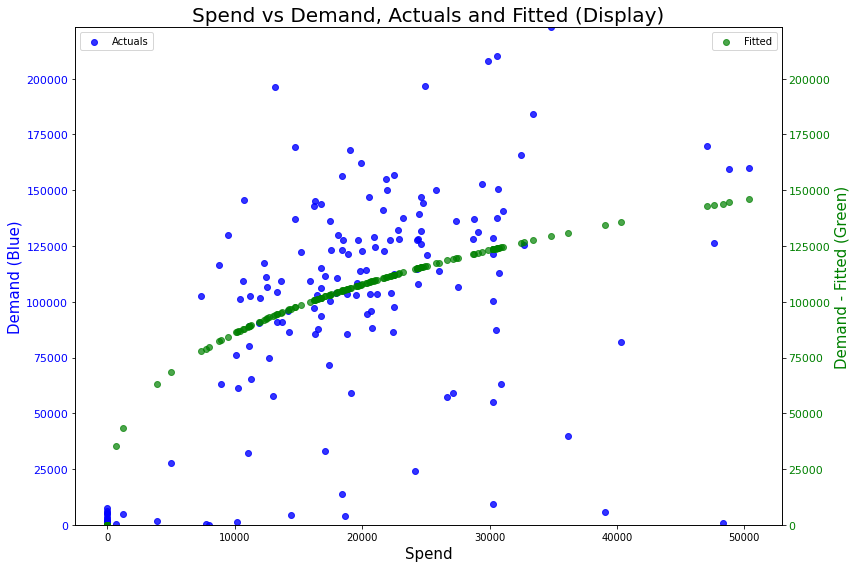

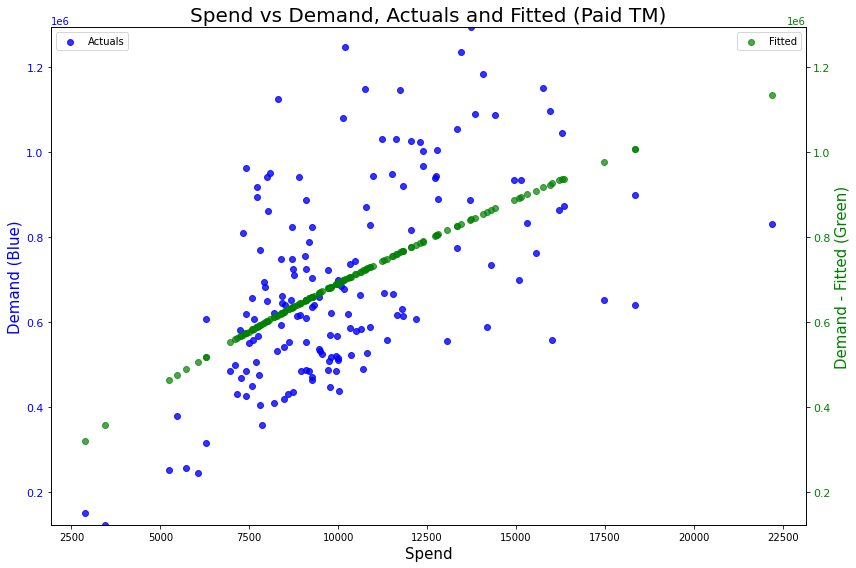

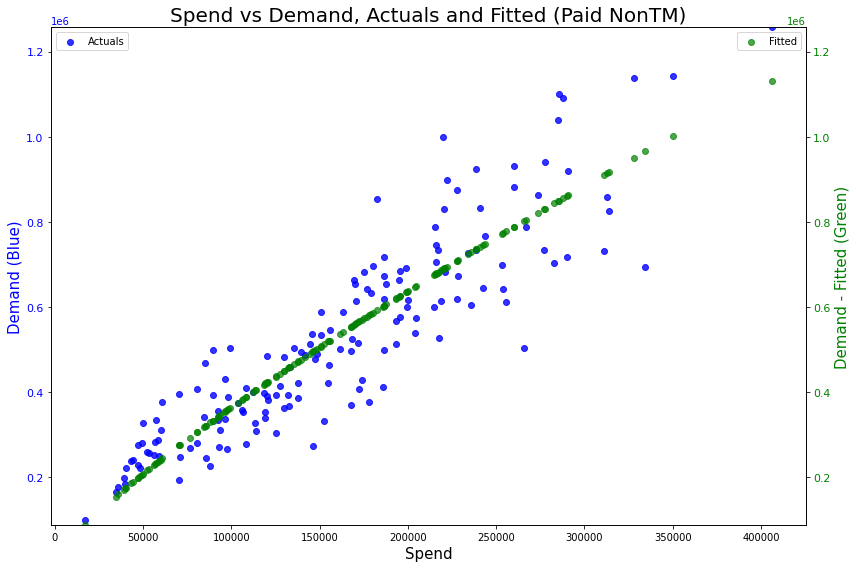

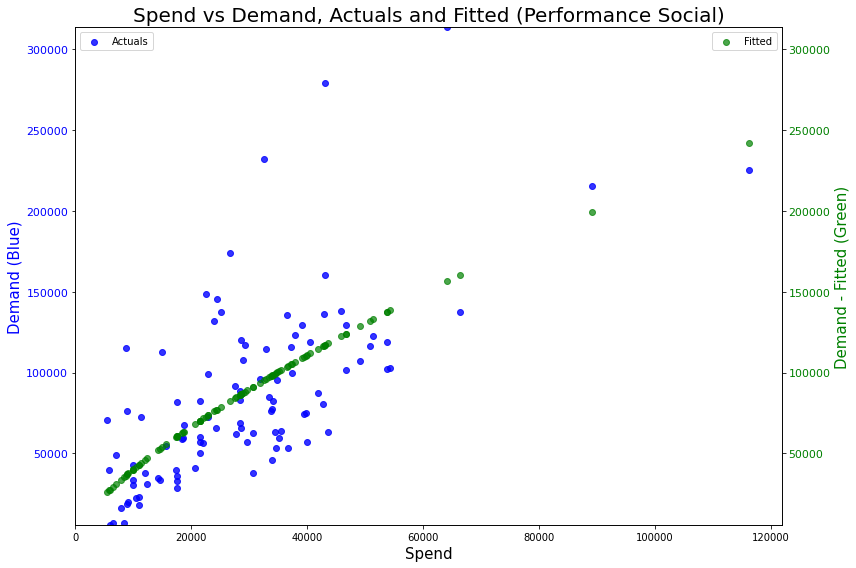

In [50]:
#Scatter Plot visualization for train demand and fit demand by marketing channel

for i,label in zip(MKT_CHNL,MKT_CHNL_Labels):
    # Create the first scatter plot
    fig, ax1 = plt.subplots(figsize=(12,8))

    # Plot data for the first y-axis
    ax1.scatter(i[['SPEND']],i[['DEMAND']], color='blue', label='Actuals', alpha=0.8)
    ax1.set_xlabel('Spend',fontsize = 15)
    ax1.set_ylabel('Demand (Blue)', color='blue',fontsize = 15)
    ax1.tick_params(axis='y', labelcolor='blue',labelsize = 11)

    ax2 = ax1.twinx()

    # Plot data for the second y-axis
    ax2.scatter(i[['SPEND']],i['Y_Fit'], color='green', label='Fitted', alpha=0.7)
    ax2.set_ylabel('Demand - Fitted (Green)', color='green',fontsize = 15)
    ax2.tick_params(axis='y', labelcolor='green',labelsize = 11)

    # Synchronize y-axis limits
    y_min = min(i['DEMAND'].min(), i['Y_Fit'].min())
    y_max = max(i['DEMAND'].max(), i['Y_Fit'].max())
    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)

    plt.title(f'Spend vs Demand, Actuals and Fitted ({label})',fontsize = 20)

    # Optional: Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.tight_layout()
    ##plt.savefig('Weekly_Prediction_vs_Test.jpg')  # Save as PDF
    plt.show()

In [51]:
##Correlation between Train Demand and Fit Demand
for i,label in zip(MKT_CHNL,MKT_CHNL_Labels):
    correlation_matrix = np.corrcoef(i['DEMAND'], i['Y_Fit'])
    R = correlation_matrix[0, 1]
    R_squared = R**2
    R_squared_pct = round(R_squared * 100,1)
    print(f'{R_squared_pct}% - {label}')

73.5% - CSE
53.1% - Affiliate
36.5% - Display
31.5% - Paid TM
80.2% - Paid NonTM
45.6% - Performance Social


In [52]:
#format results in decimal notation
parameters_floats = [[float(f"{elem:.6f}") for elem in arr] for arr in parameters]

In [53]:
for i,label in zip(parameters_floats,MKT_CHNL_Labels):
    print(f'{i} - {label}')

[0.579332, 1051.468425] - CSE
[0.529175, 2690.725823] - Affiliate
[0.327949, 4191.523003] - Display
[0.620579, 2278.851667] - Paid TM
[0.808628, 32.94757] - Paid NonTM
[0.732629, 47.093442] - Performance Social


In [54]:
parameters_floats_df = pd.DataFrame(parameters_floats)
parameters_floats_df = parameters_floats_df.rename(columns={0: 'A'})
parameters_floats_df = parameters_floats_df.rename(columns={1: 'B'})
parameters_floats_df['Marketing Channel'] = MKT_CHNL_Labels

In [38]:
print(parameters_floats_df)
parameters_floats_df

     A       B   Marketing Channel
0 0.58 1051.47                 CSE
1 0.53 2690.73           Affiliate
2 0.33 4191.52             Display
3 0.62 2278.85             Paid TM
4 0.81   32.95          Paid NonTM
5 0.73   47.09  Performance Social


,A,B,Marketing Channel
0,0.58,1051.47,CSE
1,0.53,2690.73,Affiliate
2,0.33,4191.52,Display
3,0.62,2278.85,Paid TM
4,0.81,32.95,Paid NonTM
5,0.73,47.09,Performance Social


In [39]:
parameters_floats_df.to_csv('parameters_floats_df', index=False)
##parameters_floats_df.to_excel('parameters_floats_df')